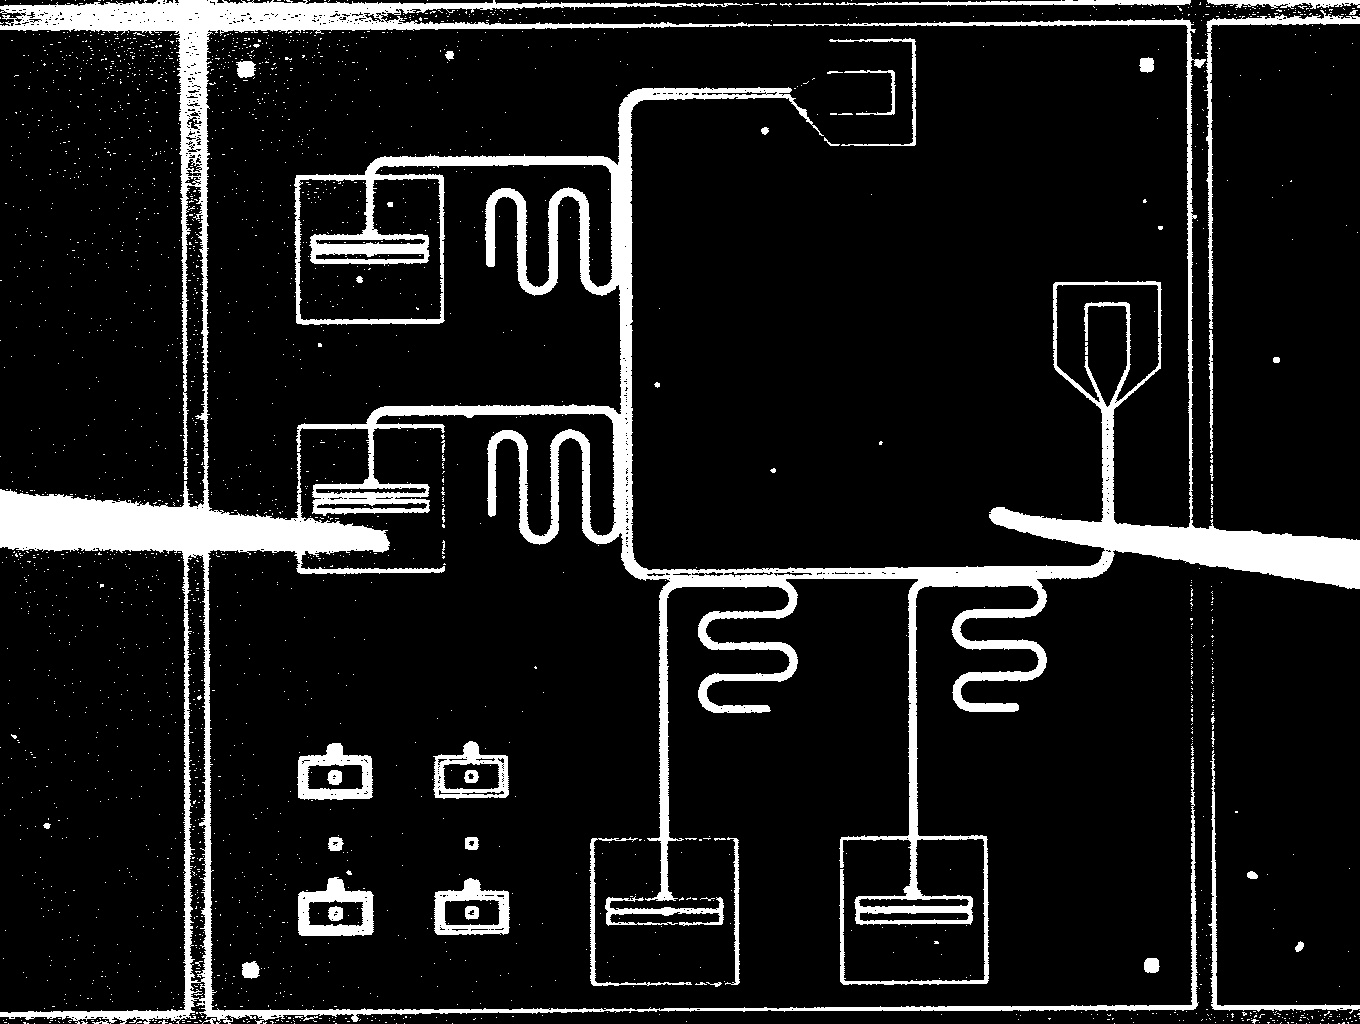

In [322]:
import cv2
import numpy as np
from IPython import display
from matplotlib import pyplot as plt

def imshow(img, format=".jpg", **kwargs):
    """ndarray 配列をインラインで Notebook 上に表示する。"""
    img = cv2.imencode(format, img)[1]
    img = display.Image(img, **kwargs)
    display.display(img)

# file_name='images/20250117134627.jpg' # Tc sample
# threshold = 30
# canny_threshold = 50

file_name='images/20250117174320.jpg' # Qubit
threshold = 60
canny_threshold = 100

img=cv2.imread(file_name)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray_blur=cv2.blur(gray,(1,1))

h,w=gray.shape[:2]
#二値化処理
thresh, gray_thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
imshow(gray_thresh)

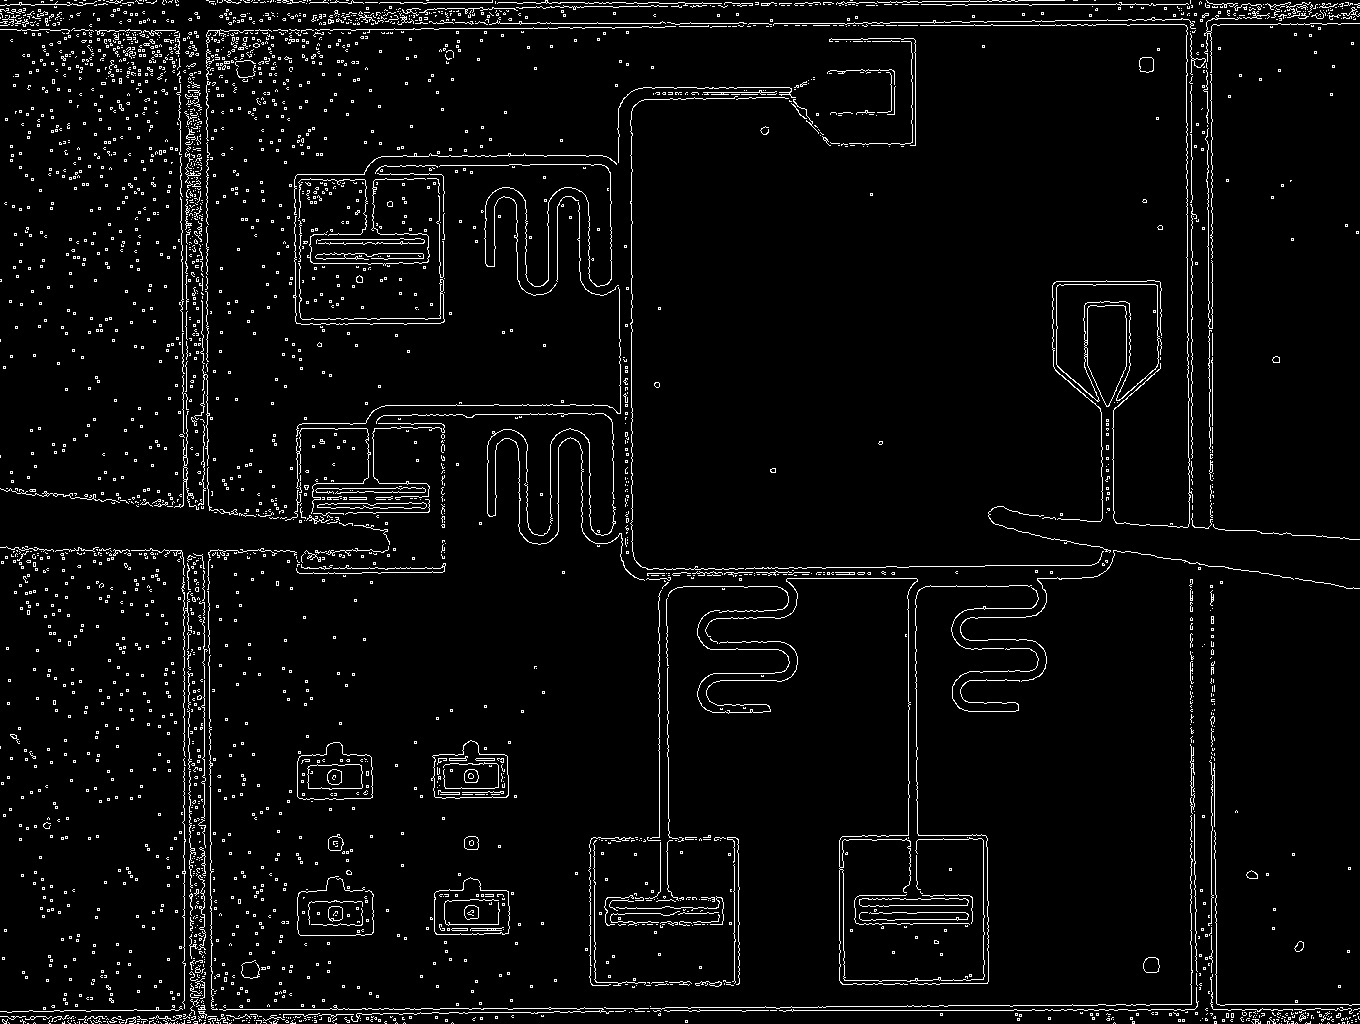

In [327]:
# エッジ検出
edges = cv2.Canny(gray_thresh, canny_threshold, 150)
imshow(edges)

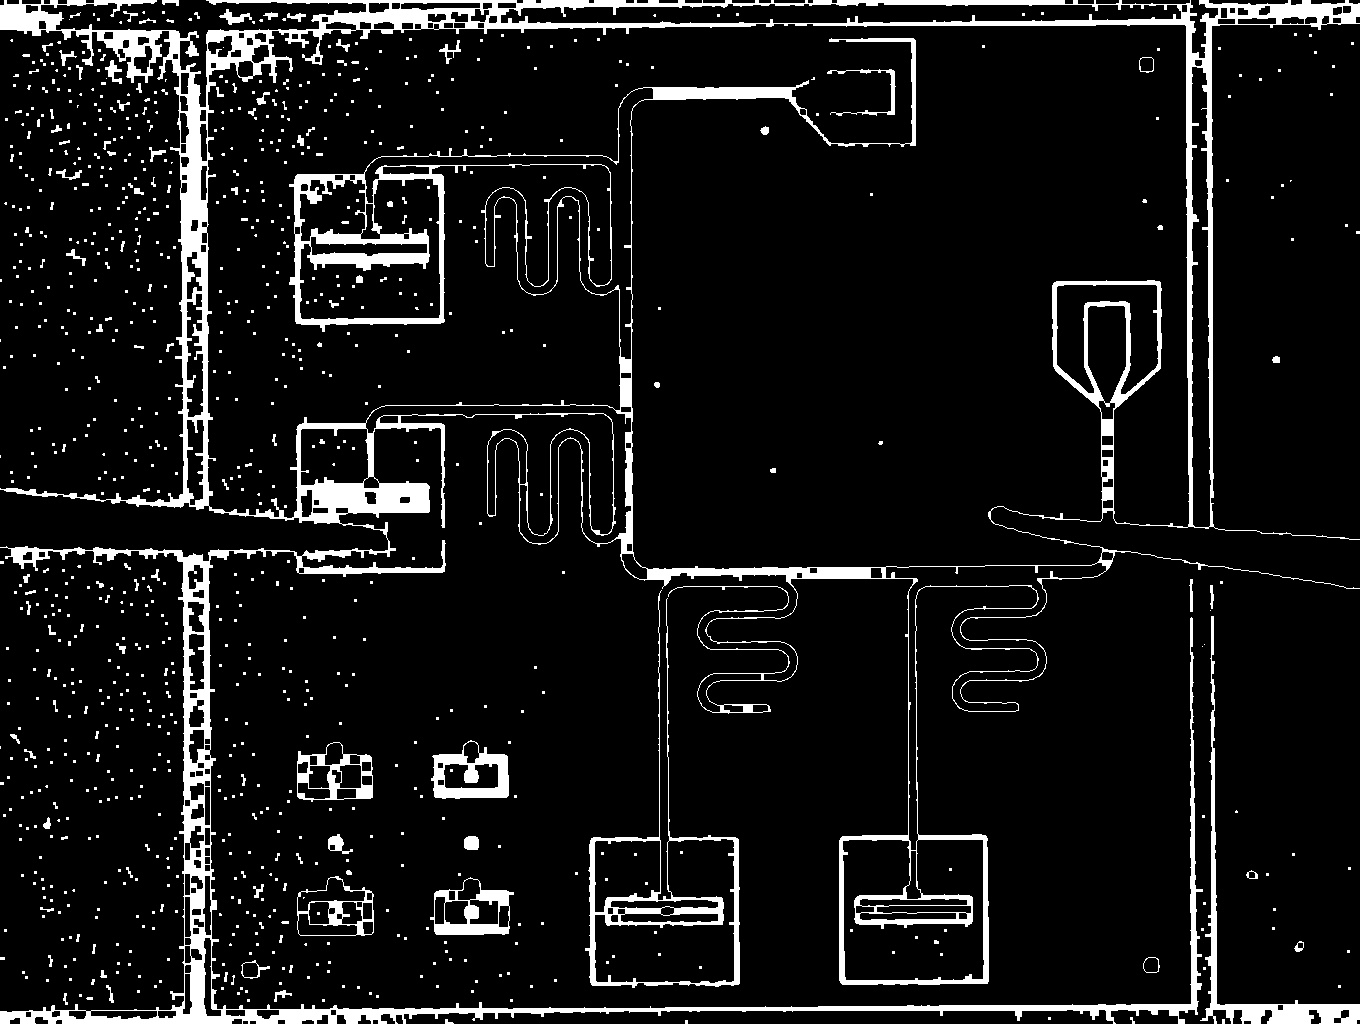

In [317]:
# モルフォロジー変換でエッジを連結
kernel = np.ones((5, 5), np.uint8)
connected_edges = cv2.dilate(edges, kernel, iterations=1)
connected_edges = cv2.erode(connected_edges, kernel, iterations=1)
imshow(connected_edges)

Found 510 Hough lines


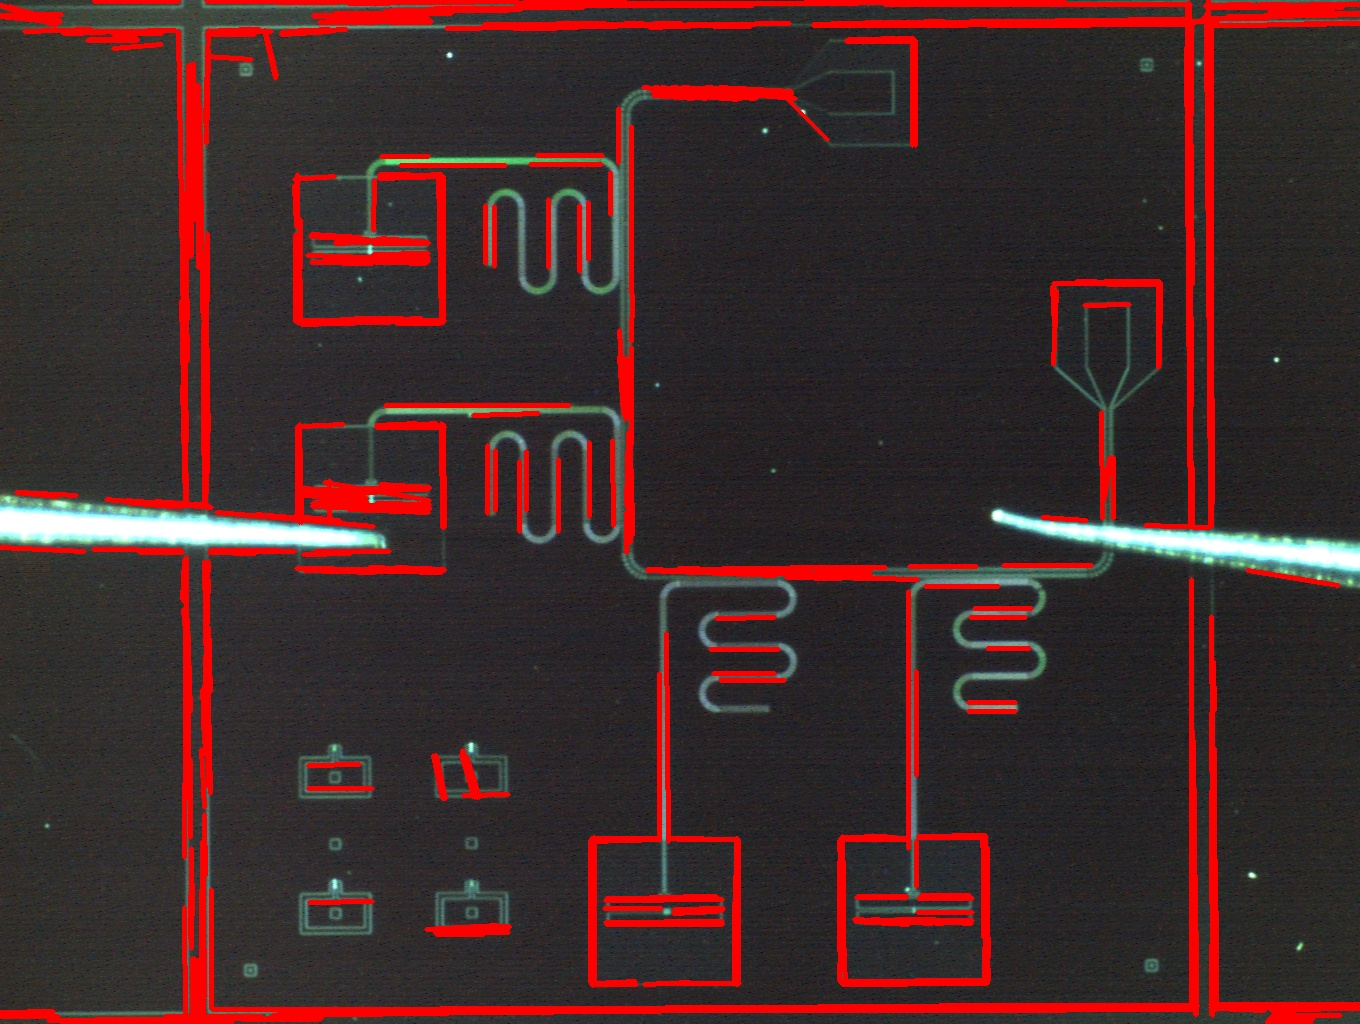

In [318]:
lines = cv2.HoughLinesP(connected_edges, 
                        rho=1, 
                        theta=np.pi/360, 
                        threshold=80, 
                        minLineLength=40, 
                        maxLineGap=5)
print( f"Found {len(lines)} Hough lines")

import copy
img_copy = copy.copy(img)
for line in lines:
    x1, y1, x2, y2 = line[0]

    # 赤線を引く
    cv2.line(img_copy, (x1,y1), (x2,y2), (0,0,255), 3)

imshow(img_copy)

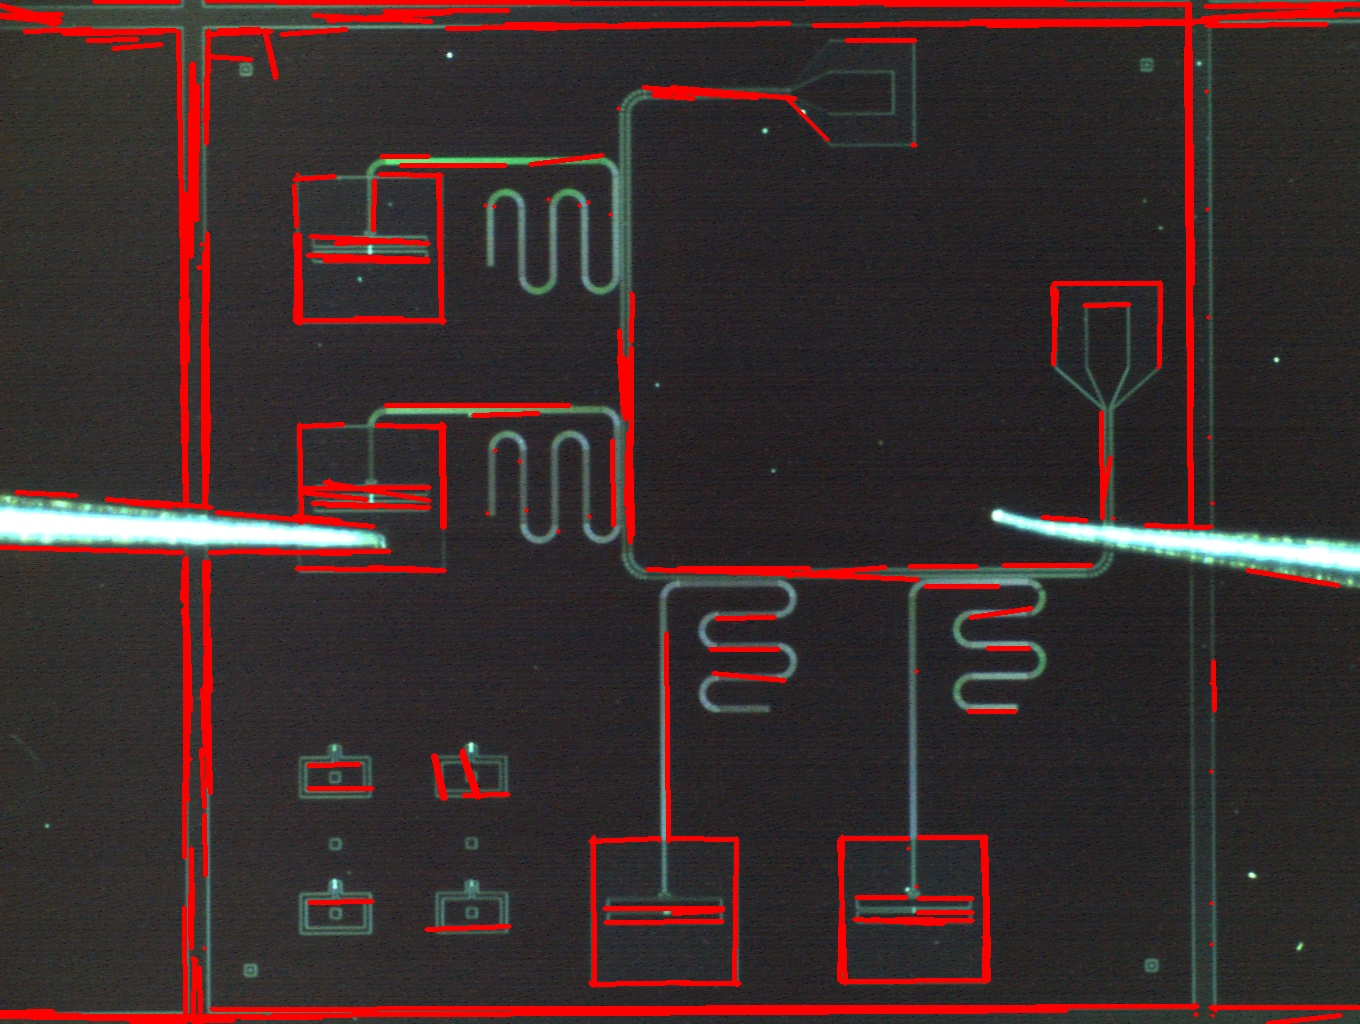

In [319]:
# 線分をマージ
def merge_lines(lines, slope_threshold=0.1, intercept_threshold=50):
    def calculate_slope_intercept(x1, y1, x2, y2):
        # 傾きと切片を計算
        if x2 - x1 == 0:  # 垂直線の場合
            return float('inf'), x1
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        return slope, intercept
    
    def distance(x1, y1, x2, y2):
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def are_endpoints_close(lineA, lineB, threshold = 10):
        x1, y1, x2, y2 = lineA[0]
        x3, y3, x4, y4 = lineB[0]
        dist = min([distance(x1, y1, x3, y3), distance(x1, y1, x4, y4), distance(x2, y2, x3, y3), distance(x2, y2, x4, y4)])
        if dist < threshold:
            return True
        return False

    merged_lines = []
    used = [False] * len(lines)

    for i, line1 in enumerate(lines):
        if used[i]:
            continue

        x1, y1, x2, y2 = line1[0]
        slope1, intercept1 = calculate_slope_intercept(x1, y1, x2, y2)
        current_group = [(x1, y1, x2, y2)]

        for j, line2 in enumerate(lines):
            if i == j or used[j]:
                continue

            x3, y3, x4, y4 = line2[0]
            slope2, intercept2 = calculate_slope_intercept(x3, y3, x4, y4)

            # 傾きと切片が近ければ同じ直線と判定
            # if abs(slope1 - slope2) < slope_threshold and abs(intercept1 - intercept2) < intercept_threshold:
            if abs(slope1 - slope2) < slope_threshold:
                if are_endpoints_close(line1, line2):
                    current_group.append((x3, y3, x4, y4))
                    used[j] = True

        # グループ化した線分を1本にマージ
        x_coords = [x1 for x1, y1, x2, y2 in current_group] + [x2 for x1, y1, x2, y2 in current_group]
        y_coords = [y1 for x1, y1, x2, y2 in current_group] + [y2 for x1, y1, x2, y2 in current_group]
        xmin_index = x_coords.index(min(x_coords))
        xmax_index = x_coords.index(max(x_coords))
        merged_lines.append([(x_coords[xmin_index], y_coords[xmin_index],x_coords[xmax_index], y_coords[xmax_index])])

    return merged_lines

# マージされた直線の取得
merged_lines = merge_lines(lines)

img_copy = copy.copy(img)
for line in merged_lines:
    x1, y1, x2, y2 = line[0]

    # 赤線を引く
    cv2.line(img_copy, (x1,y1), (x2,y2), (0,0,255), 3)

imshow(img_copy)

In [320]:
#輪郭抽出
# contours, hierarchy = cv2.findContours(gray_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(connected_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

1170


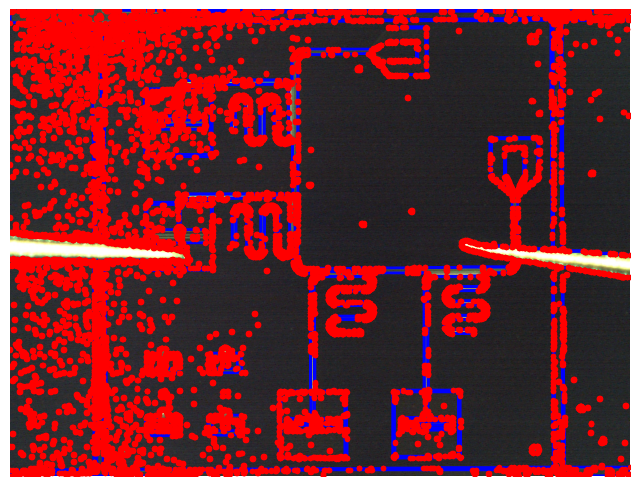

In [321]:
def draw_contours(ax, img, contours):
    ax.imshow(img)
    ax.set_axis_off()

    for i, cnt in enumerate(contours):
        # 形状を変更する。(NumPoints, 1, 2) -> (NumPoints, 2)
        cnt = cnt.squeeze(axis=1)
        # 輪郭の点同士を結ぶ線を描画する。
        ax.add_patch(plt.Polygon(cnt, color="b", fill=None, lw=2))
        # 輪郭の点を描画する。
        ax.plot(cnt[:, 0], cnt[:, 1], "ro", mew=0, ms=4)
        # 輪郭の番号を描画する。
        # ax.text(cnt[0][0], cnt[0][1], i, color="r", size="20", bbox=dict(fc="w"))


fig, ax = plt.subplots(figsize=(8, 8))
draw_contours(ax, img, contours)

plt.show()